# ODSC 2022: An Introduction to Drift Detection

To load this notebook in Google Colab [CLICK HERE](https://colab.research.google.com/github/ascillitoe/odsc_workshop/blob/main/intro_to_drift_detection.ipynb).

The notebook will run most efficiently on a GPU. To select a GPU runtime on Colab navigate to ***Runtime -> Change runtime type*** and select ***GPU*** under ***Hardware accelerator***.

## Introduction

In this workshop, you'll learn about *drift detection* through a number of tasks:

1. [Classifying newsgroups](#1.-Classifying-newsgroups) - you'll train a machine learning model to classify the topic of newsgroup posts.
2. [Performance under drift](#2.-Performance-under-drift) - You'll examine the performance of your classifier on test data that has *drifted* from the data it was trained on.
3. [Detecting drift](#3.-Detecting-drift) - You'll use the open-source [Alibi Detect](https://docs.seldon.io/projects/alibi-detect/en/latest/) library to detect a number of types of drift in a principled manner. 
4. [Accounting for context](#4.-Accounting-for-context) - To finish, you'll learn how to use a powerful drift detector which is able to take relevent context into account.

We'll also leave you with some [homework](#Homework!) to cement your newfound knowledge. After this, you'll have a good working knowledge drift detection, and will be able to apply it to your own ML tasks!

**Note:** This notebook has some sections left blank for you to fill in (marked with `???`). If you'd rather follow a completed notebook, this can be accessed [here](https://github.com/ascillitoe/odsc_workshop/blob/main/intro_to_drift_detection_master.ipynb), or loaded into Google Colab by [clicking here](https://colab.research.google.com/github/ascillitoe/odsc_workshop/blob/main/intro_to_drift_detection_master.ipynb).

## 0. Getting ready

This workshop relies on a number of files located in a [github repo](https://github.com/ascillitoe/odsc_workshop). If running locally, start by cloning the repo, and moving to the workshop directory:

```
git clone https://github.com/ascillitoe/odsc_workshop.git
cd odsc_workshop
```

If running on Google Colab, the following code will fetch the necessary files:

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    import zipfile
    import shutil
    import os

    !wget -nc https://github.com/ascillitoe/odsc_workshop/archive/refs/heads/main.zip

    pz = open('main.zip', 'rb')
    packz = zipfile.ZipFile(pz)
    packz.extractall()
    pz.close()

    srcdir = 'odsc_workshop-main/'
    for filepath in os.listdir(srcdir):
        if not os.path.exists(filepath):
            shutil.copyfile(os.path.join(srcdir, filepath), filepath)
    shutil.rmtree(srcdir)

### Software

In this workshop we'll make use of state-of-the-art drift detectors from the open-source [Alibi Detect](https://docs.seldon.io/projects/alibi-detect/en/latest/) library. To install Alibi Detect, and the other dependencies used in this workshop, run:

In [ ]:
!pip install -r requirements.txt

### Download data and sentence transformer

To download the [twenty newsgroups dataset](https://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups) and the [sentence transformer model](https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2) (more on these later), run the following:

In [ ]:
# Fetch preqrequisites
from workshop_utilities import fetch_prerequisites
dataset, sentence_transformer = fetch_prerequisites()

## 1. Classifying newsgroups

### The data

The dataset we'll explore in this workshop is the [20 newsgroup dataset](https://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups). [Usenet newsgroups](https://en.wikipedia.org/wiki/Usenet_newsgroup) have been around since the dawn of the internet, and can be thought of as the very first online social network! 

The dataset should contain about 18,000 newsgroup posts across 20 topics, including politics, science, sports and religion. Check this now! (*Note: The actual posts are stored in a list `dataset.data`, and a list of topic names is stored in `dataset.target_names`*):

In [ ]:
print(f'{len(dataset.data)} posts')
print(f'{len(dataset.target_names)} categories:')
classes = dataset.target_names
classes

To get an idea of what a post looks like, print out an instance and it's topic (*Note: The topic labels are stored as integers in `dataset.targets`. These can be used to index `dataset.target_names`*):

In [ ]:
i = 0  # instance index
post = dataset.data[i]
topic_idx = dataset.target[i]
topic = classes[topic_idx]

print(post)
print(f'Topic: {topic}')

So, each data instance looks something like an email. We wish to train a machine learning model that can take in future instances (without labels), and predict their topic. 

### Visualising the embeddings

For classification, we'll use a simple [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) model. But before that, we'll transform the posts into *semantically meaningful sentence embeddings* (*semantically meaningful* means that semantically similar sentences are close in vector space).

To extract embeddings, we'll use the pre-trained `'paraphrase-MiniLM-L6-v2'` model from the [SentenceTransformers](https://www.sbert.net/index.html) package. To see this model in action, you can checkout the [hosted HuggingFace API](https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2). The `sentence_transformer` should already have been loaded earlier, so we just need to pass it to the `EmbeddingModel` wrapper class via the `model` kwarg:

In [ ]:
from workshop_utilities import EmbeddingModel
emb_model = EmbeddingModel(model=sentence_transformer)

The sentence embeddings are high dimensional (384-d to be precise!). To visualise them, we need to first reduce their dimensionality. For this, we will train a [UMAP](https://umap-learn.readthedocs.io/en/latest/) (Uniform Manifold Approximation and Projection) model. UMAP is able to take advantage of our data labels, so we'll need to pass it the data labels (from `dataset.target`) in addition to the embeddings.

We won't need all of the 18000+ posts for training the UMAP model, so subsample the data:

In [ ]:
import numpy as np
from workshop_utilities import set_seed
set_seed(2022)  # This will ensure reproducibility (at least on CPU!)

n_train = 2000  # A larger sample here will give a better UMAP projection, but can reduce if too slow

idx_train = np.random.choice(len(dataset.data), size=n_train, replace=False)
x_train, y_train = [dataset.data[_] for _ in idx_train], dataset.target[idx_train]

The list of training posts (`x_train`) is passed through the `emb_model` to transform them into embeddings. Print out the shape of `emb_train` here to check its dimensions (they should be `(n_train, 384)`):

In [ ]:
emb_train = emb_model(x_train)
emb_train.shape

The UMAP model is provided for you in `workshop_utilities`. To train it, the embeddings `emb_train` and labels `y_train` are passed to the model's `.fit()` method:

In [ ]:
from workshop_utilities import UMAPModel
umap_model = UMAPModel()
umap_model.fit(emb_train, y=y_train)

Now use the UMAP model to obtain a 2-d representation `dr_train`of the 384-d embeddings `emb_train`:

In [ ]:
dr_train = umap_model.predict(emb_train)
dr_train.shape

We now have a 2-d representation of the sentence embeddings, from which we can visually inspect the various newsgroup topics. The `plot_clusters` utility function is provided for this:

In [ ]:
from workshop_utilities import plot_clusters
plot_clusters(dr_train, y_train, classes, title='Training data: clustered news topics')

Hopefully your data is nicely clustered by topics! The clustering is partly down to the effectiveness of the sentence transformer in extracting semantically meaningful embeddings, but it is also aided by the UMAP algorithm which has a clustering effect when used in a supervised manner(see [here](https://umap-learn.readthedocs.io/en/latest/supervised.html#using-labels-to-separate-classes-supervised-umap)).

### Training a classifier

Now to train a classifier!

In the interests of time, the `Classifier` model has been defined for you in `workshop_utilities`. The classifier is initialised with the `EmbeddingModel` you initialised earlier:

In [ ]:
from workshop_utilities import Classifier
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
clf = Classifier(embedding=emb_model).to(device)

The `Classifier` consists of a pre-trained sentence transformer model (the model you passed to `embedding`), and an MLP head. These two components are stored in the attributes `.embedding_model` and `.head`. Print out the attributes to have a look for yourself:

In [ ]:
print(clf.embedding_model)
print('')
print(clf.head)

To demonstrate *drift*, we want to start by only training the classifer on posts from two topics; cryptology (11) and space (14). The utility function `split_data` splits a dataset with a specified number of instances per class (i.e. per topic). We can use this to generate *train* and *test* data consisting of only cryptology and space posts:

In [ ]:
from workshop_utilities import split_data

n_classes = len(classes)
n_train_c = [0] * n_classes  # Sample 0 from all topics (will update below!) 
n_test_c = [0] * n_classes

n_train_c[11], n_train_c[14] = 200, 200  # subsample topics 11 & 14 only
n_test_c[11], n_test_c[14] = 100, 100  # subsample topics 11 & 14 w/ sample proportions as above

(x_train, y_train), (x_test, y_test), _ = split_data(dataset.data, dataset.target, n_train_c, n_test_c)

Check `y_train`, does it consist of only 11's and 14's?

In [ ]:
np.unique(y_train)

Use the `plot_clusters` function to visualise the training data. Is it as expected?

In [ ]:
emb_train = emb_model(x_train)
plot_clusters(emb_train, y_train, classes, dr_model=umap_model, title='Training data: clustered news topics')

If everything looks good, `x_train` and `y_train` can now be used to train the classifier! Note that training only involves the MLP head, the pre-trained embedding backbone is left untouched.

In the interests of time, the classifier has actually been trained for you. If you'd rather perform the training yourself, set `TRAIN_CLF = True`.

In [ ]:
from workshop_utilities import train_model, eval_model

TRAIN_CLF = False  # Set to TRUE to train classifier, otherwise it will be loaded from disk
filepath = 'classifier'
if TRAIN_CLF:
    # Train model
    train_model(clf, x_train, y_train, epochs=5, shuffle=True)
    clf.eval()
    # Save model
    torch.save(clf.state_dict(), filepath)
    # Check train and test accuracy
    _, _ = eval_model(clf, x_train, y_train, shuffle=True)
    _, _ = eval_model(clf, x_test, y_test, shuffle=True)
else:
    # Load model
    clf.load_state_dict(torch.load(filepath, map_location=device))
    clf = clf
    clf.eval()

### Testing the classifier

We can now run the classifier on previously unseen instances from the *test* set. If you use `plot_clusters` on the test set, you'll see that it's distribution is qualitatively similar to the *training set*; **the instances are drawn from the same distribution, but the instances are not the same**. 

In [ ]:
emb_test = emb_model(x_test)
plot_clusters(emb_test, y_test, classes, dr_model=umap_model, title='Test data: clustered news topics')

To convince yourself the classifier is working, you can run it on a few instances and examine its predictions (*Note: The classifier outputs logits, so we have to run .argmax(1) on the output to obtain a class prediction)*:

In [ ]:
idx = 42
class_pred = clf([x_test[idx]]).argmax(1)
classes[class_pred]

In [ ]:
print(classes[y_test[idx]])

## 2. Performance under drift

To artificially introduce drift, lets now introduce a new topic into our test data. Use the `split_data` function to create two datasets:

1. `(x_nodrift, y_nodrift)` - A data set with the same topic prevalence as the original test data.
2. `(x_drift, y_drift)` - A data set with the same number of instances of topics 11 and 14, but also 100 instances of topic 18 (talk.politics.misc).

In [ ]:
n_classes = len(classes)
n_nodrift_c = n_test_c
n_drift_c = [0] * n_classes

n_drift_c[11], n_drift_c[14], n_drift_c[18] = 100, 100, 100  # 

(x_nodrift, y_nodrift), (x_drift, y_drift), _ = split_data(dataset.data, dataset.target, n_nodrift_c, n_drift_c)

Use `plot_clusters` to check the new *_drift* data set:

In [ ]:
emb_drift = emb_model(x_drift)
plot_clusters(emb_drift, y_drift, classes, dr_model=umap_model, title='Drifted data: clustered news topics')

It should be clear that the new `_drift` dataset distribution is quite different to the previous test data distribution, in that there is a new topic cluster. To see the effect of this *data drift* on our classifier, use the `eval_model` function on the *_nodrift* and *_drift* data sets:

In [ ]:
_, _ = eval_model(clf, x_nodrift, y_nodrift)

In [ ]:
_, _ = eval_model(clf, x_drift, y_drift)

Unsurprisingly, the classifier does not perform well when a new topic not seen during training is introduced!

## 3. Detecting drift

As you just did, if labels (e.g. `y_`) are available at test time, harmful drift can be detected by simply evaluating your ML model's performance. However, in deployment/production, labels often aren't available. What can we do to detect drift here?

In the following sections you will use a number of different [Alibi Detect](https://docs.seldon.io/projects/alibi-detect/en/latest/) drift detectors to detect different types of drift. As you will discover, the general workflow is usually similar, with a preprocessing step, a statistical hypothesis test, and then a comparision of the resulting p-value to a certain threshold to decide if drift has occured.

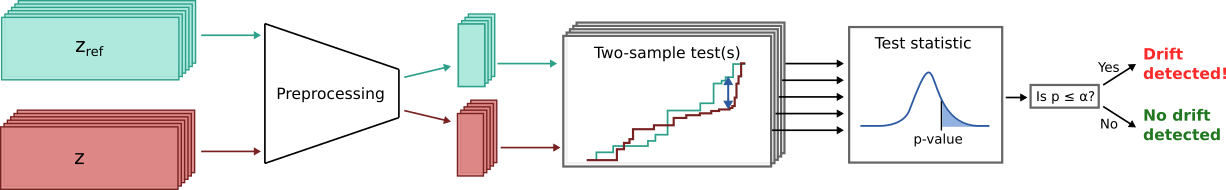

### Detecting drift on the inputs

The first type of drift we'll consider is input (covariate) drift. This is defined as $P(\mathbf{X}) \neq P(\mathbf{X}_{ref})$, i.e. input drift is said to have occured when the distribution of the input data has changed.

We can't apply a drift detector directly to the original data `x_`. Instead, we monitor the data in the embedding space. To start, we need a preprocessing function which will be applied to reference data (the data given to a detector at instantiation time) and test data (the data given to the detector's `.predict` method).

This function should: 
- Accept a list of posts `x`.
- Apply the classifier embedding model to transform `x` to the embedding space.
- Return the embeddings as a ndarray.

*Hint: the embedding model will return a `torch.Tensor`, but Alibi Detect expects `np.ndarray`'s, so you'll need to convert to this with `.cpu().numpy()`*.

In [ ]:
def preprocess_fn(x: list):
    x = ???
    return ???

<details>
<summary><b>CLICK FOR SOLUTION</b></summary>

    def preprocess_fn(x: list):
        x = clf.embedding_model(x)
        return x.cpu().numpy()

</details>

This is a good example of how you can often recycle components of your existing ML models to serve as the preprocessing stage of a drift detector. Now that you've defined the preprocessing stage, you can instantiate the actual drift detector.

Import the `MMDDrift` detector from `alibi_detect.cd`, and set the following args and kwargs (see the [MMDDrift docs](https://docs.seldon.io/projects/alibi-detect/en/latest/cd/methods/mmddrift.html) for a full list of kwargs):

- The first arg is expected to be a np.ndarray or list of reference data. This is the data we will compare to at predict time i.e. usually it will be from the same data distribution used to train the model. As a general rule, you shouldn't use the exact model training data as reference data, so instead, use the held-out `x_test` data.
- Set the `backend` kwarg to `'pytorch'`, since our classifier is a PyTorch model (the default is `'tensorflow'`).
- Set `p_val` to a decimal of your choice (the default is `0.05`). This is the p-value threshold below which we flag drift. 
- Pass your preprocess function defined above to `preprocess_fn`.

In [ ]:
from ??? import ???
x_ref = ???
dd = MMDDrift(x_ref, backend=???, p_val=???, preprocess_fn=???)

<details>
<summary><b>CLICK FOR SOLUTION</b></summary>

    from alibi_detect.cd import MMDDrift
    x_ref = x_test
    dd = MMDDrift(x_ref, backend='pytorch', p_val=.05, preprocess_fn=preprocess_fn)

</details>

Now the detector is ready to be used! Pass the `x_nodrift` data to `.predict()` to check if this data has drifted from `x_ref`:

In [ ]:
dd.??(??)

<details>
<summary><b>CLICK FOR SOLUTION</b></summary>

    dd.predict(x_nodrift)

</details>

The `predict` method returns a dictionary with the relevent predict info stored under `'data'`. The important field for us is `is_drift`, which equals `0` if no drift is detected (i.e. `'p_val'` $>$ `'threshold'`), and equals `1` if drift is detected (i.e. `'p_val'` $\le$ `'threshold'`).

Hopefully drift isn't detected above (`is_drift = 0`), meaning we have failed to reject $H_0: P(\mathbf{X}) = P(\mathbf{X}_{ref})$. Note that you might flag drift here sometimes, as a perfectly calibrated detector will still return the occasional false positive (we discuss this [later](#Important-note!)).

Now, try the same for `x_drift`:

In [ ]:
dd.??(??)['data']

<details>
<summary><b>CLICK FOR SOLUTION</b></summary>

    dd.predict(x_drift)['data']

</details>


Hopefully, drift is detected! If it is, this means there is enough evidence to reject $H_0$ and flag drift (although sometimes it might be missed, unless the detector's [test power](https://en.wikipedia.org/wiki/Power_of_a_test) is 1).

### Detecting drift on the outputs (optional!)

The next type of drift we'll consider is output (prior) drift. This is defined as $P(\mathbf{Y}) \neq P(\mathbf{Y}_{ref})$, i.e. output drift is said to have occured when the distribution of the output data (labels) has changed.

If you have access to labels `y_` you can monitor output drift by passing them directly to the detector (you can try this!). When labels are not available, the ML model's outputs can be used as a proxy for the true labels, as is done below:

*Note: You can either use the classifier's logits output, or its class predictions.*

In [ ]:
def preprocess_fn(x: list):
    x = clf(x)
    return x.detach().cpu().numpy()

In [ ]:
dd = MMDDrift(x_ref, backend='pytorch', p_val=.05, preprocess_fn=preprocess_fn)

In [ ]:
dd.predict(x_nodrift)['data']

In [ ]:
dd.predict(x_drift)['data']

### Detecting model drift

A downside (or upside!) of monitoring input/output drift is it doesn't tell you if the drift is likely to be harmful to your ML model. An alternative approach is to use a model uncertainty based detector such as the [ClassifierUncertaintyDrift](https://docs.seldon.io/projects/alibi-detect/en/latest/cd/methods/modeluncdrift.html) detector. This tests for a change in the number of instances falling into regions of the input space on which the model is uncertain in its predictions. 

Define your `ClassifierUncertaintyDrift` detector with the following args and kwargs:

- Again, the first arg should be the reference data.
- The second arg should be the ml model used to obtain uncertainties. Since our classifier provides a notion of uncertainty (the logits), this can be used directly.
- Set the `backend` and `p_val` kwargs.
- Check the [ClassifierUncertaintyDrift](https://docs.seldon.io/projects/alibi-detect/en/latest/cd/methods/modeluncdrift.html) docs to see what to set `preds_type` to.
- Set `preprocess_batch_fn=clf.embedding_model`.

In [ ]:
from alibi_detect.cd import ???


dd = ClassifierUncertaintyDrift(???, ???, 
                                preprocess_batch_fn=???, backend='pytorch', 
                                p_val=.05, preds_type=???)

<details>
<summary><b>CLICK FOR SOLUTION</b></summary>

    from alibi_detect.cd import ClassifierUncertaintyDrift

    dd = ClassifierUncertaintyDrift(x_ref, clf, 
                                    preprocess_batch_fn=clf.embedding_model, backend='pytorch', 
                                    p_val=.05, preds_type='logits')

</details>

Once instantiated, you should be able to make predictions on `x_nodrift` and `x_drift`:

In [ ]:
dd.predict(x_nodrift)['data']

In [ ]:
dd.predict(x_drift)['data']

## 4. Accounting for context

So far, **we have assumed that both the reference and test data are [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) samples from their underlying distributions**. However, in some *real world* scenarios this assumption doesn't hold. 

For example, consider the case where we have trained our classifier on a training set consisting of all twenty topics (to ensure the classifier sees a diverse range of posts during training). Now, imagine that we wish to use the classifier whilst the World Series and Stanley Cup are occuring, leading to a spike in news posts on baseball and hockey respectively. Furthermore, there is not too much news on Mac or Windows since there are no new releases or products planned anytime soon. Crucially, the distribution underlying each subpopulation (e.g. the distribution of *hockey* news itself) remains unchanged, therefore the classifier should still work well in this scenario. However, since the relative frequency of one or more subpopulations (i.e. news topics) has changed, if we assume the test instances are i.i.d (i.e. we use the standard `MMDDrift` detector), then we will detect drift.

To ensure that drift isn't flagged when the distribution underlying each subpopulation is unchanged, we need a way to provide our drift detector with relevent context (*conditioning*) information.

### Generate some example data

We can use the `split_data` to generate some data matching the scenario described above:

In [ ]:
n_classes = len(classes)
n_nochange_c = 1000 // n_classes  # equally subsample each class from 1000 instances

n_change_c = [50] * n_classes  # 50 of each class (so 1000 in total), but then mod. below.
n_change_c[4], n_change_c[5] = 5, 5  # few stories on Mac/Windows
n_change_c[9], n_change_c[10] = 95, 95  # more stories on baseball/hockey

(x_nochange, y_nochange), (x_change, y_change), (x_train, y_train) = split_data(dataset.data, dataset.target, 
                                                                      n_nochange_c, n_change_c, seed=0)

Three sets of data have been generated:

- `_nochange`: Data equally subsampled from all 20 subpopulations (topics) - *Used as reference data*.
- `_change`: Data with the prevalence of some subpopulations/topics changed - *We'll monitor this for drift*.
- `_train`: Held-out data with the same subpopulation prevalence as `_nochange` - *Used for training the classifier*.

Visualise the `no_change` embeddings. You should now see all clusters for all 20 topics:

In [ ]:
emb_nochange = emb_model(x_nochange)
plot_clusters(emb_nochange, y_nochange, classes, dr_model=umap_model, title='Reference data: clustered news topics')

### Vanilla MMD detector

Before looking at context-aware drift detection, lets see how the standard `MMDDrift` detector performs here. To save a bit of time, the embeddings are pre-computed and passed straight to the detector (so that `preprocess_fn` doesn't have to be called for both detectors). 

For the reference data `emb_ref`, the `emb_nochange` embeddings computed previously are used. To save time, the ndarray `emb_change` is also computed here:

In [ ]:
emb_ref = emb_nochange.cpu().numpy()
emb_change = emb_model(x_change).cpu().numpy()

Now init an `MMDDrift` detector, and use it to check for drift on `emb_change`:

In [ ]:
dd = MMDDrift(emb_ref, p_val=0.05, backend='pytorch', n_permutations=100)
dd.predict(emb_change)['data']

You should find that drift is consistently flagged. This is expected since the vanilla MMD detector cannot take any external context into account and correctly detects that the reference and test data do not follow the same underlying distribution. 

However, since the underlying distributions of the subpopulations are unchanged, a classifier trained on the full `x_train` should still work well on `x_change` (relative to `x_nochange`). This can be seen below:

In [ ]:
n_train = 2000
idx_train = np.random.choice(len(x_train), size=n_train, replace=False)
x_train, y_train = [x_train[_] for _ in idx_train], y_train[idx_train]

TRAIN_CLF = False  # Set to TRUE to train classifier, otherwise it will be loaded from disk
filepath = 'classifier_full'
if TRAIN_CLF:
    # init model
    clf_full = Classifier().to(device)

    # Train model
    train_model(clf_full, x_train, y_train, epochs=5, shuffle=True)
    clf_full.eval()
    
    # Save model
    torch.save(clf_full.state_dict(), filepath)
else:
    # Load model
    clf_full = Classifier()
    clf_full.load_state_dict(torch.load(filepath, map_location=device))
    clf_full = clf_full.to(device)
    clf_full.eval()

_, _ = eval_model(clf_full, x_nochange, y_nochange)
_, _ = eval_model(clf_full, x_change, y_change)

You should see a similar classification accuracy for the `_nochange` and `_change` cases above.

### Context aware MMD detector

We want to monitor whether the underlying distribution of each subpopulation has drifted, given the topic label of that subpopulation. In other words, **we wish to provide the posts' topics as context**. Since we don't have access to the true labels at test time, we instead **condition on the prediction probabilities of the classifier**. 

First, define a function `context` to:

- Take the raw embeddings `emb`. 
- Compute the `logits` with the classifier (*Hint: We need the classifier to be reasonably accurate, so remember to use the classifier trained on all 20 newsgroups*)
- Take the `logits`, and return an *ndarray* of prediction probabilities. (*Hint: you'll need the [softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) function for this.*)

In [ ]:
def context(???):
    """ Condition on classifier prediction probabilities. """
    logits = ???(???).detach()  # Important classifier trained on full dataset used here!
    softmax_fn = torch.nn.Softmax(dim=-1)
    return softmax_fn(???).cpu().numpy()

<details>
<summary><b>CLICK FOR SOLUTION</b></summary>

    def context(emb):
        """ Condition on classifier prediction probabilities. """
        logits = clf_full(emb).detach()  # Important classifier trained on full dataset used here!
        softmax_fn = torch.nn.Softmax(dim=-1)
        return softmax_fn(logits).cpu().numpy()

</details>

Now you're ready to define your [ContextMMDDrift](https://docs.seldon.io/projects/alibi-detect/en/latest/cd/methods/contextmmddrift.html) detector. Define it with the following args/kwargs:

- arg 1: The reference data, as usual. You can use `emb_ref` for this.
- arg 2: The context associated with the reference data. For this you can use your `context` function to transform `emb_ref`.
- `p_val` and `backend` kwargs as usual.
- Set `n_permutations=100` to match the `MMDDrift` detector's default (this usually defaults to 1000 for the `ContextMMDDrift`). This kwarg's controls how many permutations are used to compute the p-value. 

In [ ]:
from alibi_detect.cd import ContextMMDDrift
dd_cad = ContextMMDDrift(???, ???, p_val=.05, n_permutations=100, backend='pytorch')

<details>
<summary><b>CLICK FOR SOLUTION</b></summary>

    from alibi_detect.cd import ContextMMDDrift
    dd_cad = ContextMMDDrift(emb_ref, context(emb_ref), p_val=.05, n_permutations=100, backend='pytorch')

</details>

Now you're ready to use the detector! Try it out on the `emb_nochange` and `emb_change` data sets (*Hint: You must give the `ContextMMDDrift.predict()` method context associated with the test data*):

In [ ]:
dd_cad.predict(???, ???)['data']

In [ ]:
dd_cad.predict(???, ???)['data']

<details>
<summary><b>CLICK FOR SOLUTION</b></summary>

    dd_cad.predict(emb_nochange, context(emb_nochange))['data']
    dd_cad.predict(emb_change, context(emb_change))['data']
</details>

Hopefully drift isn't detected! We don't expect the context-aware detector to consistently flag drift, as the change in frequency of news topics is permissible given the context provided.

### Important note!

We've been a bit vauge with the word "*consistently*" above. When run many times under *no-drift*, a perfectly calibrated detector should return a uniform distribution of p-values $\mathcal{U}\left[0,1\right]$. Therefore, if you chose a p-value threshold of 0.05, you'd expect a false positive detection 5% of the time. In practice, to quantify how well calibrated a detector is, it must be run many times so that the p-value distribution under no-drift can obtained.

Below is the p-value distribution under no-drift for the context aware detector. As you can see, it is relatively well calibrated. For homework, you can generate these plots yourself for the standard and context-aware detectors!

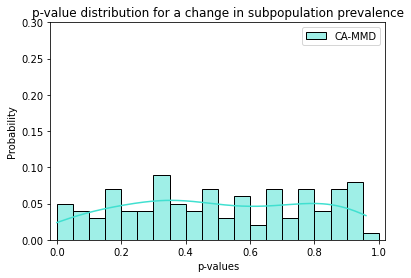

## Homework!

To learn more about drift detection, below are a number of topics you can explore in your own time.

### Examining detector calibration and test power

The performance of a drift detector can be quantified by measuring its:

- **calibration**: The distribution of calculated p-values when there is no drift. For a perfectly calibrated detector, we expect the p-values to be uniformly distributed under $U[0,1]$ when there is no drift.

- [**test power**](https://en.wikipedia.org/wiki/Power_of_a_test): probability of a "true positive" when drift is present, i.e. correctly rejecting the null hypothesis (with the null hypothesis being that there is no drift).

To measure the above quantities, we must run many experiments, instantiating detectors and making predictions on many random splits of data. To measure the calibration of the standard and context drift detectors from [section 4](#4.-Accounting-for-context) we set up the same datasets used previously. Since we need to run multiple experiments on different splits, we increase the size of the data splits to 5000 instances.

*Note: We are measuring* ***calibration*** *here, since we have set up a scenario where we don't expect drift (given the context!). You can measure* ***test power*** *in a similar way, by measuring the proportion of true positives in a scenario where you do expect drift (see this [Alibi Detect example](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_context_20newsgroup.html#Changing-the-subpopulation-distribution)).*

In [ ]:
n_classes = len(classes)
n_nochange_c = 5000 // n_classes  # equally subsample each class from 5000 instances

n_change_c = [250] * n_classes  # 250 of each class (so 5000 in total), but then mod. below.
n_change_c[4], n_change_c[5] = 50, 50  # few stories on Mac/Windows
n_change_c[9], n_change_c[10] = 450, 450  # more stories on baseball/hockey

(x_nochange, y_nochange), (x_change, y_change), _ = split_data(dataset.data, dataset.target, 
                                                               n_nochange_c, n_change_c, seed=0)

Before we set off our experiments, we compute all necessary embeddings and contexts so we don't have to run the embedding model on every loop. 

In [ ]:
emb_nochange = emb_model(x_nochange).cpu().numpy()
emb_change = emb_model(x_change).cpu().numpy()
c_nochange = context(emb_nochange) 
c_change = context(emb_change)

We're now ready to run the experiments! On each loop we re-split the `_nochange` and `_change` datasets, init new detectors, and make predictions. If it is taking too long you can reduce `n_runs`, however too few runs will result in a noisy p-value distribution. 

In [ ]:
from tqdm import tqdm

n_runs = 100
n_drift = 1000
p_vals_mmd = []
p_vals_cad = []
for run in tqdm(range(n_runs)):
    rng = np.random.default_rng(run)
    idx = rng.choice(len(x_nochange), size=n_drift, replace=False)  # assumes nochange and change are same len!

    emb_ref = emb_nochange[idx]
    emb_predict = emb_change[idx]
    c_ref = c_nochange[idx]
    c_predict = c_change[idx]
    
    dd_mmd = MMDDrift(emb_ref, p_val=0.05, n_permutations=100, backend='pytorch')
    pred_mmd = dd_mmd.predict(emb_predict)
    p_vals_mmd.append(pred_mmd['data']['p_val'])

    dd_cad = ContextMMDDrift(emb_ref, c_ref, p_val=.05, n_permutations=100, backend='pytorch')
    pred_cad = dd_cad.predict(emb_predict, c_predict)
    p_vals_cad.append(pred_cad['data']['p_val'])

The computed p-value distributions can be visualised with a histogram plot:

In [ ]:
from workshop_utilities import plot_hist

p_vals_mmd = np.array(p_vals_mmd)
p_vals_cad = np.array(p_vals_cad)

p_vals = [p_vals_mmd, p_vals_cad]
title = 'p-value distribution for a change in subpopulation prevalence'
plot_hist(p_vals, title, ylim=(0,0.5))

or we can use [Q-Q (Quantile-Quantile) plots](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot):

In [ ]:
from workshop_utilities import plot_qq
plot_qq(p_vals_mmd, 'Q-Q plot MMD detector')
plot_qq(p_vals_cad, 'Q-Q plot Context-Aware MMD detector')

A perfectly calibrated detector should have a Q-Q plot which closely follows the diagonal. Only the middle plot in the grid shows the detector's p-values. The other plots correspond to *n_runs* p-values actually sampled from $U[0,1]$ to contextualise how well the central plot follows the diagonal given the limited number of samples.


Both plots should show that the context-aware MMD detector is well-calibrated, but the normal MMD isn't! The normal MMD detector should consistently flag drift due to the change in subpopulation prevalence. The context aware drift detector should behave as if there is no drift, since  the change in subpopulation prevalence is permissible given the context provided.

### Speeding things up!

The MMD detector and context-aware MMD detector can take some time to run on large datasets. As discussed [here](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/background.html#dimension-reduction), one solution is to add a dimension reduction step to a detector's `preprocess_fn`. For example, in this Alibi Detect [IMDB text example](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_text_imdb.html#MMD-PyTorch-detector), an Untrained Auto Encoder (UAE) is used to further reduce the 768-dimensional text embedding space to a 32-d space. Applying drift detectors in this lower dimensional space is a good way to speed things up. For an advanced homework task, you can try adding a dimension reduction step to the preprocessors used in this workshop.

### Delving deeper into context-aware drift detection

If the distribution of the subpopulations changes (instead of just the frequency), we would now expect the context-aware detector to flag drift. You can check this for yourself by adopting the dataset used in this Alibi Detect [newsgroups example](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_context_20newsgroup.html#Changing-the-subpopulation-distribution).

We've only touched the surface of context-aware drift detection today. The detector can be applied to many different tasks by changing the context that is supplied. For more details, see the [ContextMMDDrift docs](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/contextmmddrift.html), the [newsgroup example](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_context_20newsgroup.html), and the [ecg example](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_context_ecg.html).


### Interpretability of detections

Sometimes you might want to interpret your drift detections in order to understand why drift is occuring. There are a number of things you can explore here:

- **Feature-level attribution**: Some of the detectors listed [here](https://docs.seldon.io/projects/alibi-detect/en/stable/overview/algorithms.html) return a p-value for each feature, meaning you can attribute a drift detection to certain features. 
- **Instance-level attribution**: Some detectors, such as [ClassifierDrift](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/classifierdrift.html) return instance-level predictions, allowing you to attribute drift to certain instances.
- **Detectors designed for interpretability**: The [SpotTheDiff](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods/spotthediffdrift.html) detector is specifically designed to give detections that are interpretable at the feature level when they occur.

If you follow the "Examples" links at the bottom of each drift detector docs page, you can explore how some of the above capability can be used. We are also working on detection methods which take advantage of our ML interpretability library [Alibi Explain](https://docs.seldon.io/projects/alibi/en/latest/), so watch this space!

### Online drift detection

A final thing we haven't covered today is "online" drift detection. The describes the scenario when test instances arrive sequentially instead of in batches. In such a scenario it is important for the detector to be well calibrated (we desire a certain Expected Run Time in the absense of drift), yet it flag drift quickly when it is present. Alibi Detect offers a number of state-of-the-art [online detectors](https://docs.seldon.io/projects/alibi-detect/en/stable/cd/methods.html#online) that are designed to meet these requirements. For more info, see [this paper](https://arxiv.org/abs/2108.00883) and a related YouTube video: [Protecting Your Machine Learning Against Drift: An Introduction](https://www.youtube.com/watch?v=tL5sEaQha5o).

The syntax for the online detectors is consistent with the offline detectors used in this workshop:

```python
# Init detector
from alibi_detect.cd import MMDDriftOnline
detector = MMDDriftOnline(x_ref, ERT, W, backend='pytorch', preprocess_fn=encoder_fn)

# Make a prediction on a test instance
detector.predict(x)
```

For a good example, check out the [medical imaging example](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/cd_online_camelyon.html).

## Follow-up questions

Any follow-up questions or problems? Please feel free to get in touch at ashley.scillitoe@seldon.io 